In [31]:
# !/usr/bin/env python3
import pandas as pd
import os
import requests

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Read all .frt files from the data/ directory and concatenate them into a single DataFrame
list_df = []
for file in os.listdir("data/"):
    if file.endswith(".frt"):
        df = pd.read_feather(f"data/{file}")
        list_df.append(df)
data = pd.concat(list_df, ignore_index=True)
del list_df

In [33]:
# Display time range of the data
print("Data time range:")
display(data["TRADEDATE"].sort_values(ascending=True).reset_index(drop=True))

Data time range:


0         2019-09-12
1         2019-09-12
2         2019-09-12
3         2019-09-12
4         2019-09-12
             ...    
650871    2025-09-19
650872    2025-09-19
650873    2025-09-19
650874    2025-09-19
650875    2025-09-19
Name: TRADEDATE, Length: 650876, dtype: object

In [34]:
# Volume of the dataset
observation_count, parameter_count = data.shape
print(
    f"Observation count: {observation_count}",
    f"Parameter count: {parameter_count}",
    sep="\n",
)

Observation count: 650876
Parameter count: 24


In [35]:
# Display unique values in the BOARDID column and filter the DataFrame by "TQBR"
display(data["BOARDID"].value_counts())
data = data[data["BOARDID"] == "TQBR"]  # main trading board
observation_tqbr, parameter_tqbr = data.shape
print(
    f"Observation count after filtering by TQBR: {observation_tqbr}",
    f"Parameter count after filtering by TQBR: {parameter_tqbr}",
    sep="\n",
)
print(observation_count - observation_tqbr, "observations were removed")

BOARDID
TQBR    385281
TQIF    125960
TQTF    104814
TQTD     16449
TQPI     12004
TQTE      2914
TQFD      2765
TQTY       441
TQDE       248
Name: count, dtype: int64

Observation count after filtering by TQBR: 385281
Parameter count after filtering by TQBR: 24
265595 observations were removed


In [36]:
# Get securities information from MOEX ISS API
url = (
    "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
)
response = requests.get(url)
response.raise_for_status()  # Check for request errors
securities = pd.DataFrame(
    response.json()["securities"]["data"],
    columns=response.json()["securities"]["columns"],
)
display(response.json()["securities"]["metadata"])

{'SECID': {'type': 'string', 'bytes': 36, 'max_size': 0},
 'BOARDID': {'type': 'string', 'bytes': 12, 'max_size': 0},
 'SHORTNAME': {'type': 'string', 'bytes': 30, 'max_size': 0},
 'PREVPRICE': {'type': 'double'},
 'LOTSIZE': {'type': 'int32'},
 'FACEVALUE': {'type': 'double'},
 'STATUS': {'type': 'string', 'bytes': 3, 'max_size': 0},
 'BOARDNAME': {'type': 'string', 'bytes': 381, 'max_size': 0},
 'DECIMALS': {'type': 'int32'},
 'SECNAME': {'type': 'string', 'bytes': 90, 'max_size': 0},
 'REMARKS': {'type': 'string', 'bytes': 24, 'max_size': 0},
 'MARKETCODE': {'type': 'string', 'bytes': 12, 'max_size': 0},
 'INSTRID': {'type': 'string', 'bytes': 12, 'max_size': 0},
 'SECTORID': {'type': 'string', 'bytes': 12, 'max_size': 0},
 'MINSTEP': {'type': 'double'},
 'PREVWAPRICE': {'type': 'double'},
 'FACEUNIT': {'type': 'string', 'bytes': 12, 'max_size': 0},
 'PREVDATE': {'type': 'date', 'bytes': 10, 'max_size': 0},
 'ISSUESIZE': {'type': 'int64'},
 'ISIN': {'type': 'string', 'bytes': 36, 'm

In [37]:
# Filter securities to include only common shares (SECTYPE == "1") and primary listings (LISTLEVEL == 1)
display(securities["LISTLEVEL"].value_counts())
display(securities["SECTYPE"].value_counts())
# Filter for primary listings of common shares
securities = securities.loc[
    (securities["LISTLEVEL"] == 1) & (securities["SECTYPE"] == "1")
]

# Filter the main DataFrame to include only securities present in the filtered securities list
data = data[data["SECID"].isin(securities["SECID"])]
observation_1st_level, parameter_1st_level = data.shape
print(
    f"Observation count after filtering by primary listings: {observation_1st_level}",
    f"Parameter count after filtering by primary listings: {parameter_1st_level}",
    sep="\n",
)
print(observation_tqbr - observation_1st_level, "observations were removed")

LISTLEVEL
3    162
1     66
2     30
Name: count, dtype: int64

SECTYPE
1    207
2     48
D      3
Name: count, dtype: int64

Observation count after filtering by primary listings: 72100
Parameter count after filtering by primary listings: 24
313181 observations were removed


In [38]:
print("Unique SECID count:", data["SECID"].nunique())

Unique SECID count: 61


In [39]:
# Calculate the correlation matrix of daily returns for the securities
corr_matrix = (
    data.pivot(index="TRADEDATE", columns="SECID", values="CLOSE")
    .sort_index(ascending=True)
    .fillna(method="ffill")
    .pct_change()
    .corr()
    .copy()
)
display(corr_matrix)

SECID,AFKS,AFLT,ALRS,AQUA,ASTR,BELU,BSPB,CBOM,CHMF,CNRU,...,SVCB,T,TATN,TGKA,UPRO,VKCO,VSEH,VTBR,X5,YDEX
SECID,,,,,,,,,,,,,,,,,,,,,
AFKS,1.000000,0.556982,0.575990,0.353494,0.410850,0.227412,0.414709,0.490211,0.585887,0.273054,...,0.562302,0.758060,0.562744,0.503274,0.513244,0.537739,0.360988,-0.022977,0.383713,0.705707
AFLT,0.556982,1.000000,0.495728,0.360681,0.453672,0.219284,0.386549,0.437224,0.499212,0.137095,...,0.547739,0.722558,0.463498,0.486948,0.476531,0.584460,0.373168,-0.022280,0.392551,0.673663
ALRS,0.575990,0.495728,1.000000,0.321871,0.391334,0.221930,0.378459,0.481266,0.521920,0.226040,...,0.565765,0.731139,0.574072,0.488306,0.458112,0.470042,0.359271,-0.042189,0.414579,0.710300
AQUA,0.353494,0.360681,0.321871,1.000000,0.392182,0.211696,0.280732,0.307610,0.275341,0.273739,...,0.525552,0.513972,0.313280,0.325500,0.311501,0.457868,0.392667,-0.014611,0.346028,0.560682
ASTR,0.410850,0.453672,0.391334,0.392182,1.000000,0.140306,0.378186,0.306273,0.428005,0.189528,...,0.517633,0.590638,0.334853,0.428952,0.392511,0.449340,0.297760,-0.027189,0.306055,0.592356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VKCO,0.537739,0.584460,0.470042,0.457868,0.449340,0.306767,0.297151,0.429893,0.436157,0.176636,...,0.566884,0.694892,0.442701,0.357673,0.380148,1.000000,0.347650,-0.020337,0.211960,0.667974
VSEH,0.360988,0.373168,0.359271,0.392667,0.297760,0.085372,0.282425,0.324123,0.374060,0.293916,...,0.365650,0.383718,0.299623,0.363749,0.347804,0.347650,1.000000,-0.059281,0.207049,0.391972
VTBR,-0.022977,-0.022280,-0.042189,-0.014611,-0.027189,-0.010593,-0.030725,-0.040460,-0.039427,0.203927,...,-0.049319,0.635701,-0.016705,-0.012745,0.000934,-0.020337,-0.059281,1.000000,0.342554,0.635488


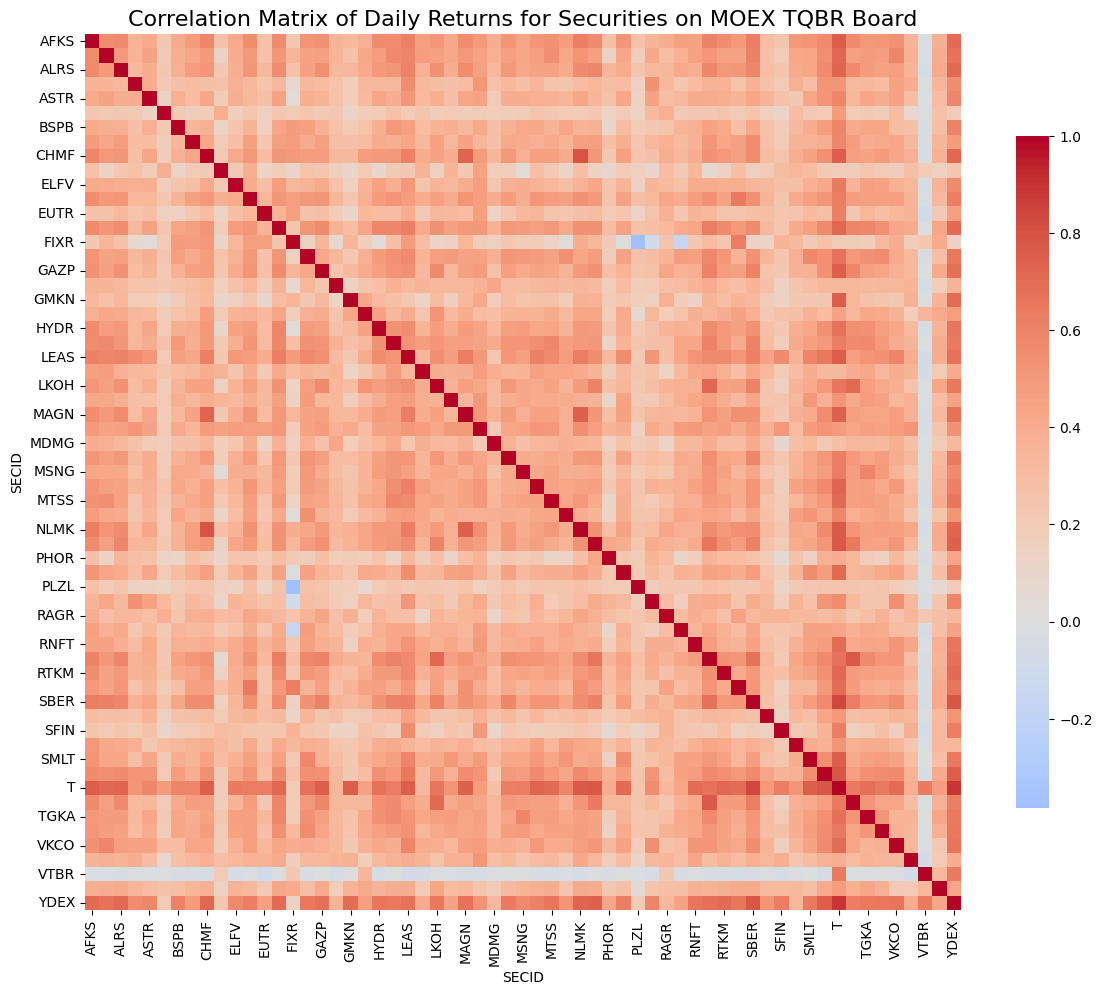

In [40]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.75},
)
plt.title(
    "Correlation Matrix of Daily Returns for Securities on MOEX TQBR Board", fontsize=16
)
plt.tight_layout()